# NST distribution categorical evolution
This looks at the evolution of the NST distributions as n, the number of stimuli events known by the model, increases. The NST distributions are categorized into one of four categories describing whether the distribution of responses is deterministic or not, and whether it is spiking or not.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")
import HH, Stimuli
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms
import time
import pandas as pd
import seaborn as sns

In [2]:
data_dir = './data/nst_distribution_evolution/'
figures_dir = './figures/'

## Load Data

In [3]:
results_files = os.listdir(f'{data_dir}results/')

results_stimuli_ids = [int(f.split('_')[1]) for f in results_files]

In [4]:
ns = [n for n in range(3, 21)]
num_histories = 1000
stim_types = ['base','lw','lt','lwlt','burst']

## spike determinism criteria
Here we define a metric to determine if a set of responses are deterministic or not.

In [5]:
# spike determinism criteria
spike_ratio_upper_bound = 0.99
spike_ratio_lower_bound = 0.01
nst_std_limit = .1 #ms

In [6]:
spike_ratios = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': []
}
spike_ratios_df = []

spike_determinism = {
    'base': {n:[] for n in ns},
    'lw': {n:[] for n in ns},
    'lt': {n:[] for n in ns},
    'lwlt': {n:[] for n in ns},
    'burst': {n:[] for n in ns}
}

progress = 0.0
print('______PROGRESS______')
for i, file in enumerate(results_files):
    stim_type = file.split('_')[0]
    stim_id = int(file.split('_')[1])
    stim_ind = int((file.split('_')[2]).strip('.json'))
    with open(f'{data_dir}results/{file}', 'r') as fin:
        results = json.load(fin)
    _spike_ratios = []
    for n in ns:
        spike_ratio = np.sum(~np.isnan(results[str(n)])) / num_histories
        _spike_ratios.append(spike_ratio)
        
        if spike_ratio < spike_ratio_lower_bound:
            spike_determinism[stim_type][n].append('deterministic nonspiking')
        elif spike_ratio > spike_ratio_upper_bound:
            if np.nanstd(results[str(n)]) < nst_std_limit:
                spike_determinism[stim_type][n].append('deterministic spiking')
            else:
                spike_determinism[stim_type][n].append('non-deterministic spiking')
        else:
            spike_determinism[stim_type][n].append('non-deterministic')
            
        #spike_ratios_df.append([stim_type, stim_id, stim_ind, n, spike_ratio])
    spike_ratios[stim_type].append(_spike_ratios)
    spike_ratios_df.append([stim_type, stim_id, stim_ind]+_spike_ratios)
        
    if progress < i/len(results_files):
        print('=', end='')
        progress+=0.05

______PROGRESS______

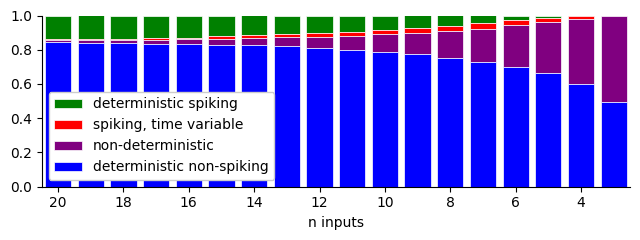

In [7]:
stim_type = 'base'

plt.figure(figsize=(6.5,2.5))

det_non_spike = []
non_det = []
non_det_spike = []
det_spike = []

for n in ns:
    det_non_spike.append(spike_determinism[stim_type][n].count('deterministic nonspiking'))
    non_det.append(spike_determinism[stim_type][n].count('non-deterministic'))
    non_det_spike.append(spike_determinism[stim_type][n].count('non-deterministic spiking'))
    det_spike.append(spike_determinism[stim_type][n].count('deterministic spiking'))

total_count = det_non_spike[0] + non_det[0] +non_det_spike[0] + det_spike[0]
    
det_non_spike = np.array(det_non_spike) / total_count
non_det = np.array(non_det) / total_count
non_det_spike = np.array(non_det_spike) / total_count
det_spike = np.array(det_spike) / total_count
    
lw = 0.5
width = .8
plt.bar(ns, det_spike, bottom = det_non_spike + non_det+non_det_spike, color='green', edgecolor='white', lw=lw, width=width)
plt.bar(ns, non_det_spike, bottom = det_non_spike + non_det, color='red', edgecolor='white', lw=lw, width=width)
plt.bar(ns, non_det, bottom = det_non_spike, color='purple', edgecolor='white', lw=lw, width=width)
plt.bar(ns, det_non_spike, color='blue', edgecolor='white', lw=lw, width=width)



plt.xlim(2.5,20.5)
plt.ylim(0,1)

plt.xlabel('n inputs')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(
    ['deterministic spiking','spiking, time variable','non-deterministic','deterministic non-spiking'],
    loc='lower left', framealpha=1, fontsize=10
)

plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig(f'{figures_dir}nst_dist_evolution_determinism.svg', format='svg')
plt.savefig(f'{figures_dir}nst_dist_evolution_determinism.png', format='png', dpi=300)

plt.show()

In [8]:
spike_ratio_differences = []

for stim_type in stim_types:
    for _spike_ratios in spike_ratios[stim_type]:
        for i, n in enumerate(ns[:-1]):
            spike_ratio_differences.append([stim_type, f'{n}:{n+1}', _spike_ratios[i] - _spike_ratios[i+1]])

In [9]:
df = pd.DataFrame(spike_ratio_differences, columns=['stim_type','n_col','spike_ratio_difference'])

In [10]:
df['spike_ratio_difference_abs'] = np.abs(df['spike_ratio_difference'])

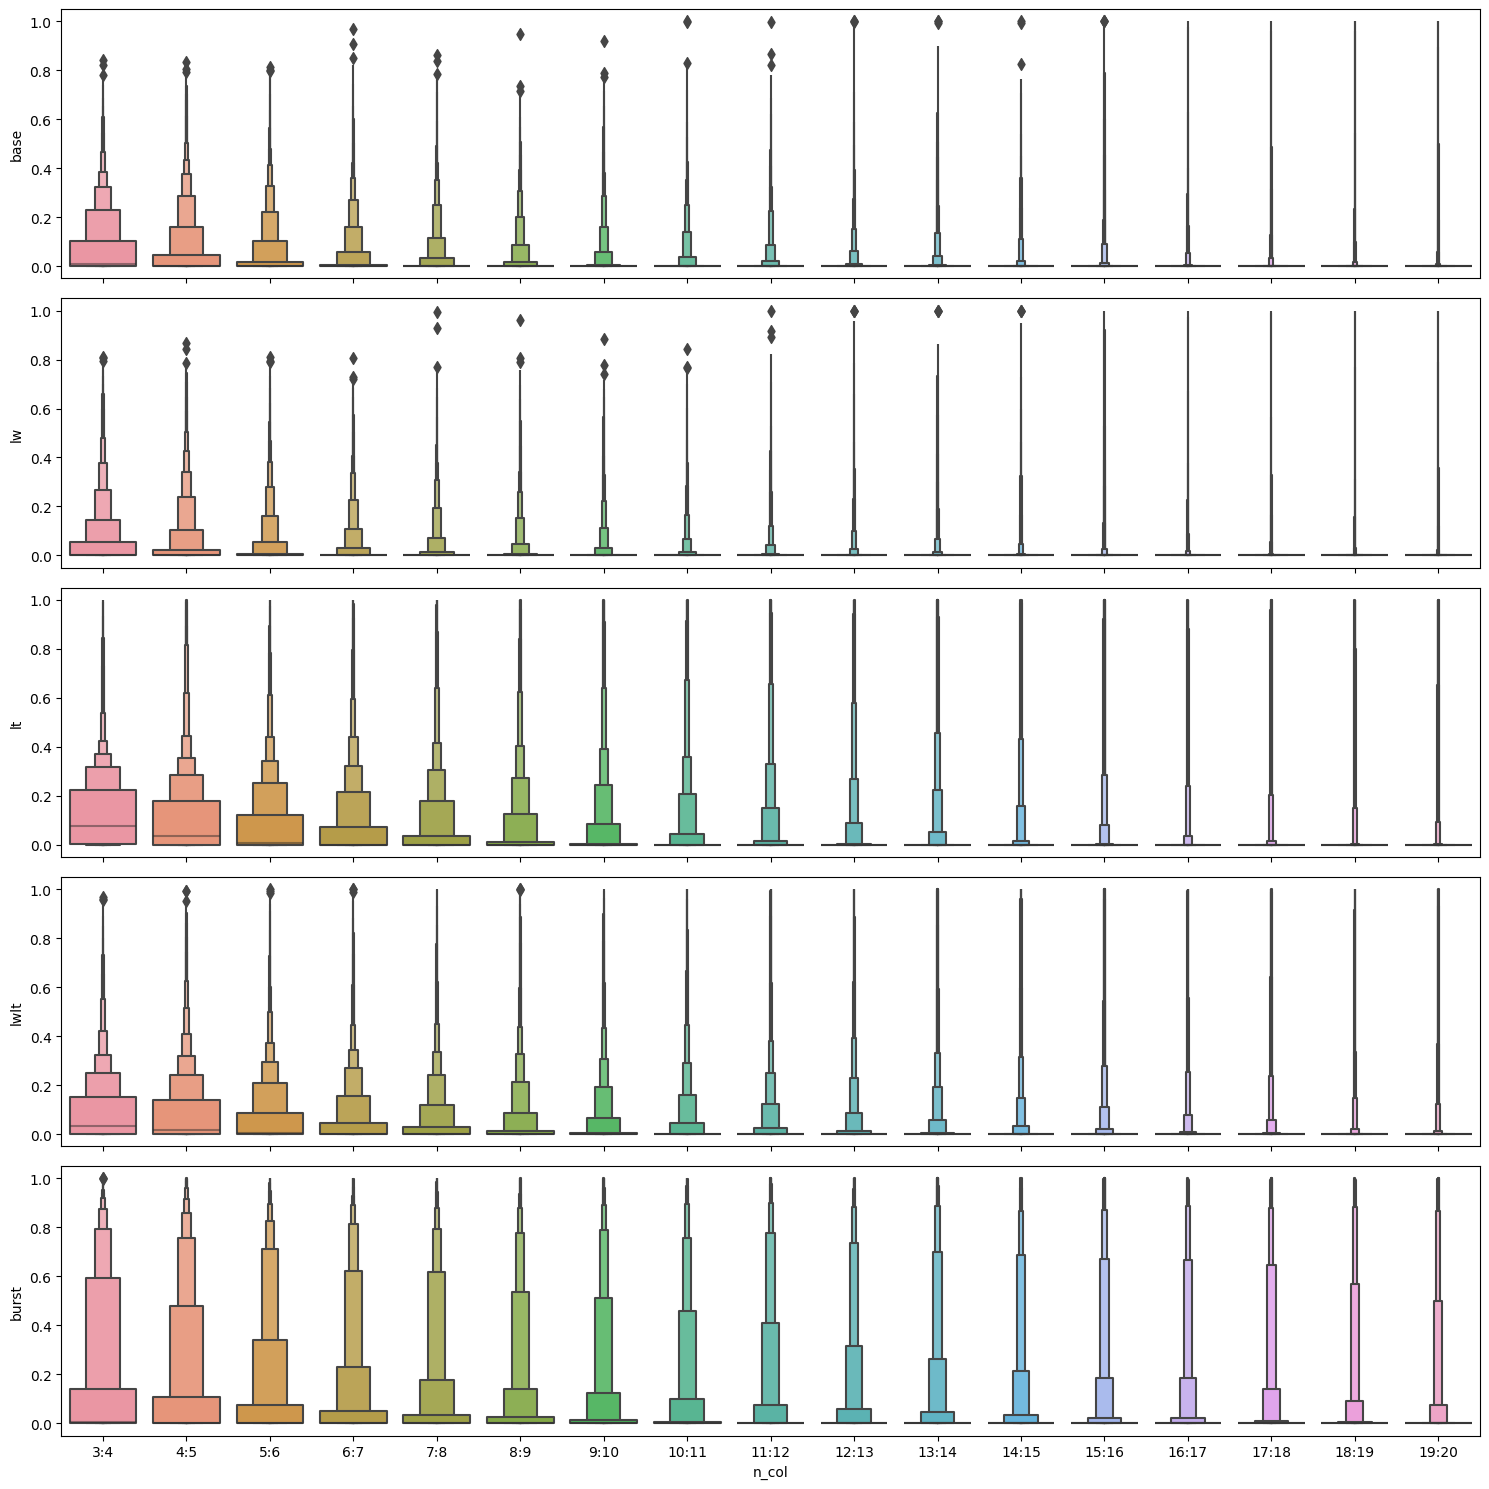

In [11]:
fig, axes = plt.subplots(5,1, figsize=(15,15), sharex=True, layout='tight')

for i, stim_type in enumerate(stim_types):
    sns.boxenplot(data = df[df['stim_type'] == stim_type], 
                  x='n_col', y = 'spike_ratio_difference_abs', ax=axes[i], k_depth="trustworthy")
    
    axes[i].set_ylabel(stim_type)
    if i != 4:
        axes[i].set_xlabel('')

plt.show()